In [1]:
from sklearn.datasets import load_iris
from random import randint
from random import random as uni_prob
import numpy as np
import pandas as pd
import copy
from sklearn import metrics

In [2]:
iris = load_iris(as_frame=True)
data = iris.data
target = iris.target

In [3]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [5]:
class Chromosome:

  def find_clusters(self):
      for i in range(self.clusters_num):
        for j in range(self.data_point_num):
          if self.arr[j] == i:
            self.clusters[i].append(j)

  def change_cluster(self,data_point_id,from_i,to_j):
    # works fine!
    self.clusters[from_i].remove(data_point_id)
    self.clusters[to_j].append(data_point_id)

  def __init__(self,clusters_num,data_point_num) -> None:
    self.clusters_num = clusters_num
    self.data_point_num = data_point_num
    self.arr = np.random.randint(clusters_num,size=data_point_num)

    self.clusters = []
    for i in range(clusters_num):
      self.clusters.append([])
    self.find_clusters()

    self.fitness_num , self.mids = self.fitness()


  def fitness(self, mode = 'centroid'):
    mids = np.zeros((self.clusters_num,data.shape[1]))
    if mode == 'centroid':
      num = 0
      for i in range(self.clusters_num):
        ids = self.clusters[i]
        if len(ids) == 0:
          continue
        cluster_members = data.iloc[ids,:].to_numpy()
        mid = cluster_members.mean(axis=0)
        num += sum(sum((cluster_members-mid)**2))
        mids[i] = mid
      self.fitness_num = 1/(0.0001+num)
      self.mids = mids
      return 1/(0.0001+num) , mids
    else:
      return metrics.silhouette_score(data,target,sample_size=50)



  def mutate(self,mode='change_to_nearest_centroid'):
    # random cluster change
    # TODO: a more interesting mutation
    if mode == 'random_label_change':
      i = randint(0,self.data_point_num-1)
      new_cluster = randint(0,self.clusters_num-1)
      self.change_cluster(i,self.arr[i],new_cluster)
      self.arr[i] = new_cluster
      self.fitness()
    elif mode == 'change_to_nearest_centroid':
      # changes the data point cluster to nearest centroid
      rand_ids = randint(0,self.data_point_num-1)
      random_data_point = np.array(data.iloc[rand_ids,:])
      random_data_point_nearest_centroid_ids = np.argmin(np.sum((self.mids-random_data_point)**2,axis=1))
      self.change_cluster(rand_ids,self.arr[rand_ids],random_data_point_nearest_centroid_ids) # mids index is the same as cluster index
      self.arr[rand_ids] = random_data_point_nearest_centroid_ids
      self.fitness()

  def cross(self,chromosome):
    # makes a child by randomly changing labels between two cut points
    # TODO: add mode where data in some cluster in A become one cluster in B and vice versa
    cut1 = randint(0,self.data_point_num-1)
    cut2 = randint(0,self.data_point_num-1)
    cut1,cut2 = min(cut2,cut1),max(cut2,cut1)
    if cut1 == cut2:
      return
    child = copy.deepcopy(self)
    for i in range(cut1,cut2):
        child.change_cluster(i,child.arr[i],chromosome.arr[i])
        child.arr[i] = chromosome.arr[i]
    # child.find_clusters()
    child.fitness()
    if child is None:
      raise Exception('NoneType in Cross')
    return child

    # pass

        # temp1 = self.arr[i]
        # temp2 = chromosome.arr[i]

        # self.change_cluster(i,temp1,temp2)
        # self.arr[i] = temp2

        # chromosome.change_cluster(i,temp2,temp1)
        # chromosome.arr[i] = temp1


In [6]:
def init_population(pop_size,clusters_num,data_point_num):
  population = []
  for i in range(pop_size):
    population.append(Chromosome(clusters_num,data_point_num))
  return population

In [7]:
def comp_key(x):
  if x.fitness_num is not None:
    return x.fitness_num
  else:
    x.fitness()
    return x.fitness_num

In [8]:
class GeneticClustering:
    def __init__(self,pop_size=500,clusters_num=3,data_point_num=data.shape[0],elitePer=0.1,mutation_rate=0.3):
      self.pop_size = pop_size
      self.population = init_population(pop_size,clusters_num,data_point_num)
      self.elite_num = round(elitePer*pop_size)
      self.non_elite = self.pop_size - self.elite_num
      self.mutation_rate = mutation_rate

    def evolve(self,generations=10) -> Chromosome:
        # evolves for # generations and returns best chromosome
        for i in range(generations):

          # passing the elites to next gen
          self.population.sort(key=comp_key,reverse=True)
          new_population = copy.deepcopy(self.population)

          # cross over
          for j in range(self.elite_num+1, self.pop_size):
            parent1 = self.population[randint(0,self.elite_num-1)]
            parent2 = self.population[j]
            child = parent1.cross(parent2)
            while child is None:
              child = parent1.cross(parent2)
            if child.fitness_num >= parent2.fitness_num/2 or uni_prob()<0.1: # replace chromosome with child, only if the result is better or with a very low probability
              new_population[j] = child
          # mutation
          for j in range(self.pop_size):
              if uni_prob()<self.mutation_rate:
                new_population[j].mutate()

          # next gen
          self.population = new_population

        return max(self.population,key=comp_key)


In [9]:
genClust = GeneticClustering()
bestClust = genClust.evolve(50)

In [10]:
bestClust.arr

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
bestClust.fitness_num

0.011461109700934759

In [12]:
metrics.adjusted_rand_score(target, bestClust.arr)

0.7311985567707746

In [13]:
metrics.homogeneity_completeness_v_measure(target, bestClust.arr)

(0.7608008469718723, 0.7795958005591144, 0.7700836616487869)

In [14]:
metrics.silhouette_score(data,bestClust.arr)

0.5046794496058261

In [15]:
metrics.silhouette_score(data,target)

0.5034774406932966

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

In [18]:
mids_2d = pca.transform(bestClust.mids)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


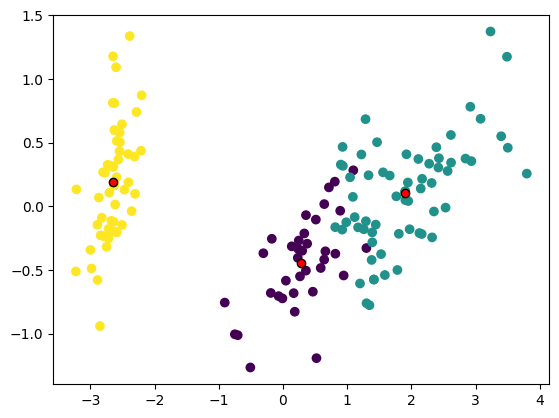

In [19]:
plt.scatter(x=data_2d[:,0],y=data_2d[:,1],c=bestClust.arr)
plt.scatter(x=mids_2d[:,0],y=mids_2d[:,1],c='red',edgecolors='black')
plt.show()

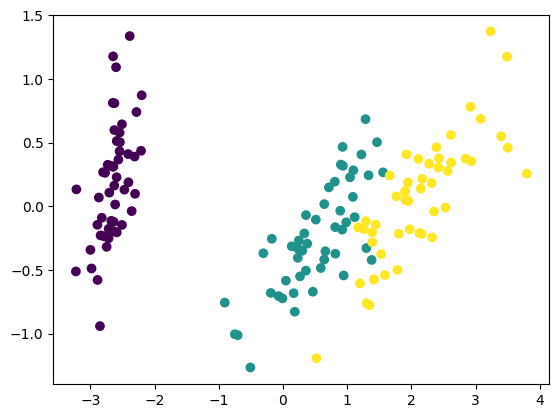

In [20]:
plt.scatter(x=data_2d[:,0],y=data_2d[:,1],c=target)
plt.show()

In [22]:
from sklearn.cluster import KMeans

In [26]:
kmeans = KMeans(n_clusters=3,init='k-means++',n_init=10)

In [27]:
kmeans.fit(data)

KMeans(n_clusters=3, n_init=10)

In [28]:
kmeans_mids_2d = pca.transform(kmeans.cluster_centers_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


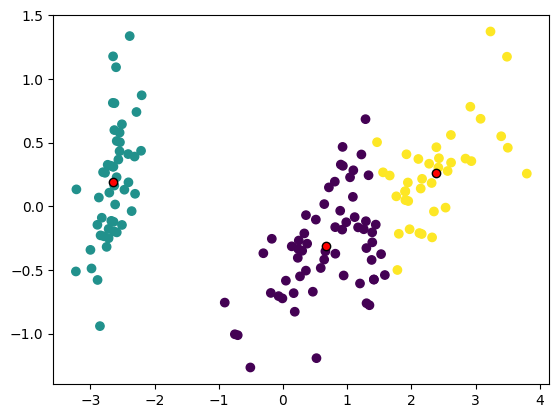

In [30]:
plt.scatter(x=data_2d[:,0],y=data_2d[:,1],c=kmeans.labels_)
plt.scatter(x=kmeans_mids_2d[:,0],y=kmeans_mids_2d[:,1],c='red',edgecolors='black')
plt.show()

In [31]:
metrics.adjusted_rand_score(target, kmeans.labels_)

0.7302382722834697

In [32]:
metrics.homogeneity_completeness_v_measure(target, kmeans.labels_)

(0.7514854021988338, 0.7649861514489815, 0.7581756800057784)

In [33]:
metrics.silhouette_score(data,kmeans.labels_)

0.5528190123564102